In [40]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator
from astropy.cosmology import Planck13 as cosmo

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sea
# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon, F_lam_per_M
import fsps
from spec_id import Scale_model
from spec_tools import Oldest_galaxy, Photometry
from spec_stats import Highest_density_region

import dynesty
from dynesty import plotting as dyplot
from glob import glob

from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 20})

In [12]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = True) 

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [14]:
def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [63]:
Oldest_galaxy(1.607)

4.02784827230877

In [58]:
# dres = np.load('../data/out_dict/GSD_41520_assembly.npy').item()

In [12]:
dres.logl

array([-9.05526312e+08, -6.98235651e+08, -4.33058411e+08, ...,
       -2.21844241e+02, -2.21713367e+02, -2.21474426e+02])

In [15]:
md = np.zeros(7)
le = np.zeros(7)
he = np.zeros(7)

for i in range(7):
    t,pt = Get_posterior(dres.samples[:,i + 8],dres.logwt,dres.logz)
    md[i], le[i], he[i] = Highest_density_region(pt,t)

In [16]:
T,PT = Get_posterior(dres.samples[:,7],dres.logwt,dres.logz)
age, agel, ageh = Highest_density_region(PT,T)

In [19]:
LBT = Time_bins(Oldest_galaxy(1.607))

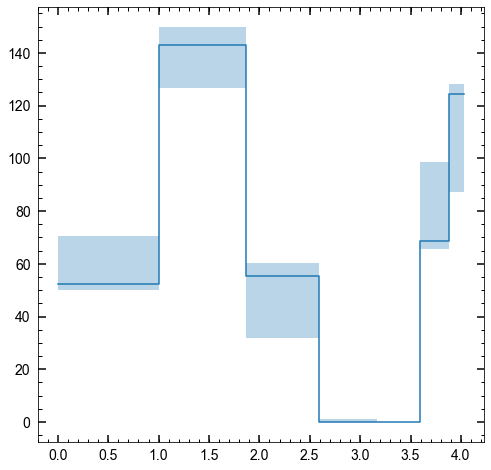

In [20]:
t= np.arange(0,6,.1)
plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(md[0],md))
plt.fill_between(np.append(0,LBT),np.append(md[0],md) - np.append(le[0],le),
                 np.append(md[0],md) + np.append(he[0],he), step = 'pre',alpha = .3)

# plt.axvline(age)
# plt.axvspan(agel,ageh,alpha=0.3)

# plt.plot(t, t * np.exp(-t / 0.533) * 4.5)

In [42]:
def Time_bins(agelim):
    lbt = np.array([0, 0.1, 0.3, 0.6, 1])
    return np.round(agelim  - lbt / 1.5 * agelim, 2)[::-1]

def get_50(field, galaxy):
    bfZ, bft, bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bfz, bfd = np.load('../data/bestfits/{0}_{1}_bestfit.npy'.format(field, galaxy))

    agelim = Oldest_galaxy(bfz)
    LBT = Time_bins(agelim)

    md = [bftau1, bftau2, bftau3, bftau4, bftau5, bftau6]
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < bft]
    hrtime = hrtime[hrtime < bft]
    mass /= mass[-1]

    return interp1d(mass,hrtime)(0.5)

In [73]:
hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
dt = 0.001
mass = np.zeros(len(hrtime))
mbu = 0
u = 0
for i in range(len(hrtime)):
    if hrtime[i] > LBT[u]:
        u+=1
    mass[i] = mbu
    mbu += md[u] * dt
    
mass = mass[hrtime < age]
hrtime = hrtime[hrtime < age]
mass /= mass[-1]

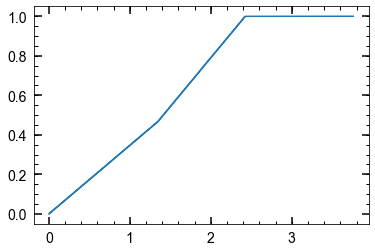

In [74]:
plt.plot(hrtime,mass)

In [44]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

Gs = Gen_spec('GSD', 41520, 1.607,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = True) 

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [22]:
bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bft,bftau1,bftau2,bftau3,bftau4,bftau5,bftau6,bftau7,bfd,bfm = dres.samples[-1]

In [23]:
bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bft,bftau1,bftau2,bftau3,bftau4,bftau5,bftau6,bftau7,bfd,bfm 

(1.5251573803904142,
 1.108099382093243,
 1.4178026483521693,
 1.4580976011503997,
 1.4509825501200846,
 0.6571509595071047,
 0.25939900857487375,
 3.577352448809205,
 52.05889728166203,
 145.00552164631964,
 33.01492550599091,
 0.35432292848483493,
 0.10897754661767634,
 68.67766763768431,
 125.12515310073861,
 0.10036038462938479,
 11.023438528547716)

In [24]:
LBT

array([1.00696207, 1.87007241, 2.58933103, 3.16473793, 3.5962931 ,
       3.88399655, 4.02784827])

In [25]:
sp.params['dust2'] =bfd
sp.params['dust1'] =bfd

# LBT = Time_bins(bft)

sp.set_tabular_sfh(LBT,np.array([bftau1,bftau2,bftau3,bftau4,bftau5,bftau6,bftau7]), 
                   Z = np.array([bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7])*0.019)

# sp.set_tabular_sfh(LBT,np.array([80,100,2,.1,.1,.1,0]), 
#                    Z = np.array([.4,.8,1,1,1,1,1])*0.019)

wave, flux = sp.get_spectrum(tage =bft, peraa = True)

# specz = 1.25257 
specz = 1.607

Gs.Sim_all_premade(wave*(1+specz),flux)

In [26]:
conv = cosmo.luminosity_distance(1.607).value *4 * np.pi

(3.0, 4.6020599913279625)

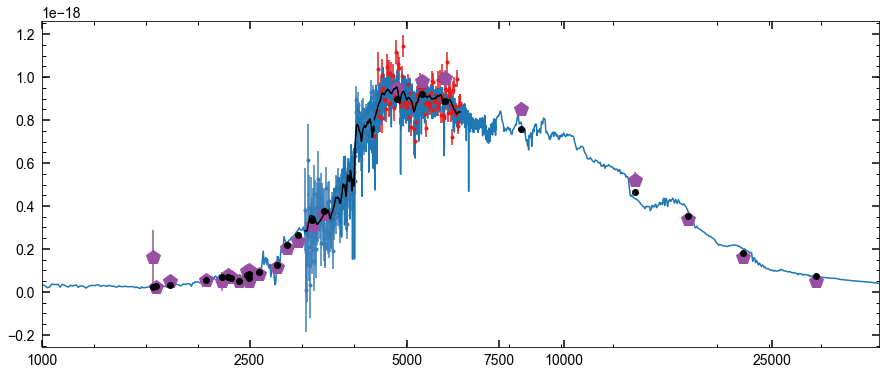

In [33]:
# Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, specz)

# PC= Full_scale(Gs, Pmfl)

# Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl, 'ko', zorder=5)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.plot(np.log10(wave * (1)),flux  / (10**bfm*1E9 * conv))
plt.xlim(np.log10(1000), np.log10(40000))

In [56]:
(sum(((Gs.Bfl - Gs.Bmfl) / Gs.Ber)**2) + sum(((Gs.Rfl - Gs.Rmfl) / Gs.Rer)**2) + sum(((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2)) * (-0.5)

-235.96446439759274

In [72]:
bres.logl

array([-5.66778335e+05, -5.37174917e+05, -4.59616094e+05, ...,
       -3.18452548e+02, -3.18430947e+02, -3.18195384e+02])

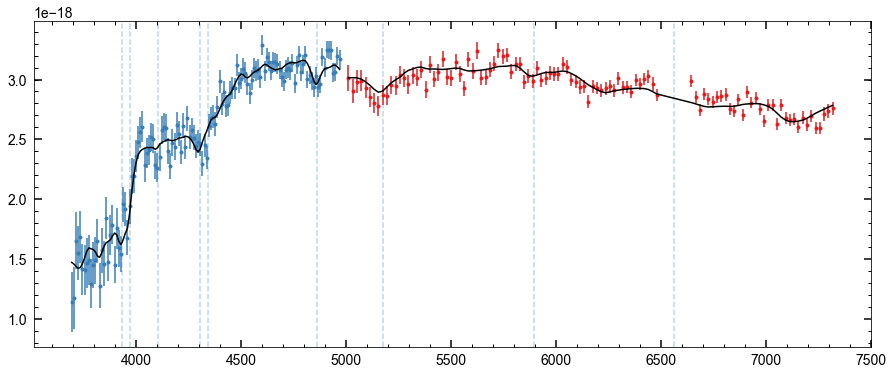

In [20]:
plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv_rf,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Gs.Rwv_rf,Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(Gs.Bwv_rf, Gs.Bmfl, 'k', zorder=5)
plt.plot(Gs.Rwv_rf, Gs.Rmfl, 'k', zorder=5)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)
plt.axvline(6564,linestyle='--', alpha=.3)

In [176]:
phot = Photometry(Gs.Rwv,Gs.Rfl,Gs.Rer,1)

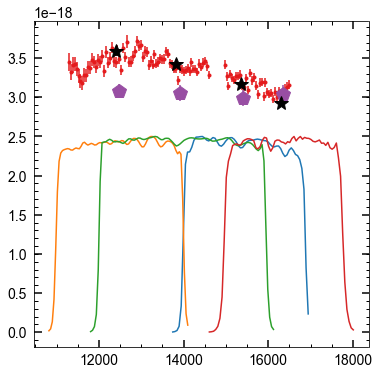

In [177]:
plt.figure(figsize = [6,6])
plt.errorbar(Gs.Rwv,Gs.Rfl*1.08,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')

for i in range(len(Gs.Pnum)):
    if Gs.Rwv[0] < Gs.Pwv[i] < Gs.Rwv[-1]:
        plt.errorbar(Gs.Pwv[i],Gs.Pflx[i],Gs.Perr[i],
                                 linestyle='None', marker='p', markersize=15, color='#984ea3') 
        phot.Get_Sensitivity(filter_num=int(Gs.Pnum[i]))
        
        plt.plot(phot.sens_wv, phot.trans * 2.5E-18)
        
        try:
            phot.Photo_clipped()

            plt.errorbar(phot.eff_wv,phot.photo*1.08,phot.photo_er,
                                     linestyle='None', marker='*', markersize=15, color='k') 
            
        except:
            print('skip')

In [178]:
photB = Photometry(Gs.Bwv,Gs.Bfl,Gs.Ber,1)

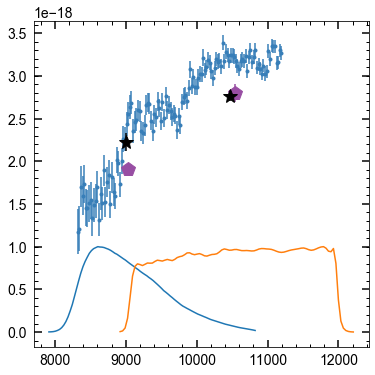

In [179]:
plt.figure(figsize = [6,6])
plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8')

for i in range(len(Gs.Pnum)):
    if Gs.Bwv[0] < Gs.Pwv[i] < Gs.Bwv[-1]:
        plt.errorbar(Gs.Pwv[i],Gs.Pflx[i],Gs.Perr[i],
                                 linestyle='None', marker='p', markersize=15, color='#984ea3') 
        photB.Get_Sensitivity(filter_num=int(Gs.Pnum[i]))
        
        plt.plot(photB.sens_wv, photB.trans / 1E18)
        
        try:
            photB.Photo_clipped()

            plt.errorbar(photB.eff_wv,photB.photo,photB.photo_er,
                                     linestyle='None', marker='*', markersize=15, color='k') 
            
        except:
            print('skip')

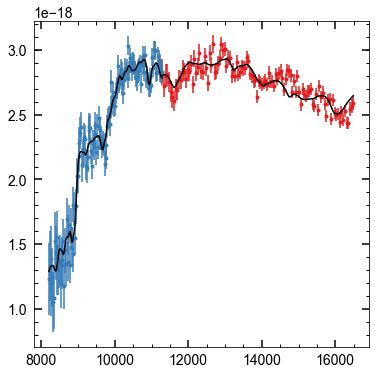

In [156]:
plt.figure(figsize = [6,6])
plt.errorbar(Gs.Rwv,Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8')

plt.plot(Gs.Bwv, Gs.Bmfl, 'k', zorder=5)
plt.plot(Gs.Rwv, Gs.Rmfl, 'k', zorder=5)

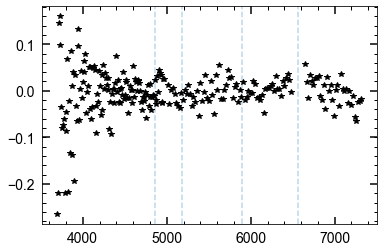

In [173]:
plt.plot(Gs.Bwv_rf,((Gs.Bfl - Gs.Bmfl) / Gs.Bfl), 'k*', zorder=5)
plt.plot(Gs.Rwv_rf,((Gs.Rfl - Gs.Rmfl) / Gs.Rfl), 'k*', zorder=5)

# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)
plt.axvline(6564,linestyle='--', alpha=.3)

In [82]:
12.25 - 9.75, 12.25 - 1.25

(2.5, 11.0)

In [55]:
specz = 1.2526
agelim = Oldest_galaxy(specz)

def prior_transform(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = agelim * u[1] + 0.01
    t1 = u[2]
    t2 = u[3]
    t3 = u[4]
    t4 = u[5]
    t5 = u[6]  
    t6 = u[7]    
    z = specz + 0.002*(2*u[8] - 1)
    d = 2*u[9]
    
    return [m, a, t1, t2, t3, t4, t5, t6, z, d]

def assembly_prior(u):
    m1 = (0.03 * u[0] + 0.001) / 0.019
    m2 = (0.03 * u[1] + 0.001) / 0.019
    m3 = (0.03 * u[2] + 0.001) / 0.019
    m4 = (0.03 * u[3] + 0.001) / 0.019
    m5 = (0.03 * u[4] + 0.001) / 0.019
    
    a = agelim * u[5] + 0.01
    
    t1 = u[6]
    t2 = u[7]
    t3 = u[8]
    t4 = u[9]
    t5 = u[10]  
    
    d = 1*u[11]
    
    return [m1, m2, m3, m4, m5, a, t1, t2, t3, t4, t5, d]

def assembly_prior_2(u):
    m1 = (0.03 * u[0] + 0.001) / 0.019
    m2 = (0.03 * u[1] + 0.001) / 0.019
    m3 = (0.03 * u[2] + 0.001) / 0.019
    m4 = (0.03 * u[3] + 0.001) / 0.019
    m5 = (0.03 * u[4] + 0.001) / 0.019
    m6 = (0.03 * u[5] + 0.001) / 0.019
    m7 = (0.03 * u[6] + 0.001) / 0.019
    
    a = (agelim - LBT[0])* u[7] + LBT[0]
    
    t1 = 150 * u[8]
    t2 = 150 * u[9]
    t3 = 150 * u[10]
    t4 = 150 * u[11]
    t5 = 150 * u[12]  
    t6 = 150 * u[13]  
    t7 = 150 * u[14]  
    
    d = 1*u[15]
    
#     m = 11.0 + 1.25*(2*u[16] - 1)
    
#     return [m1, m2, m3, m4, m5, m6, m7, a, t1, t2, t3, t4, t5, t6, t7, d, m]
    return [m1, m2, m3, m4, m5, m6, m7, a, t1, t2, t3, t4, t5, t6, t7, d]

def rshift_prior(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = 7 * u[1] + 0.01   
    t = 1.5 * u[2] + 0.01
    z = 2.5*u[3]
    d = 2*u[4]
    return [m, a, t, z, d]

def bfit_prior(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = agelim * u[1] + 0.1
    t1 = u[2]
    t2 = u[3]
    t3 = u[4]
    t4 = u[5]
    t5 = u[6]  
    t6 = u[7]    
    d = 2*u[8]
    
    return [m, a, t1, t2, t3, t4, t5, t6, d]

In [56]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_scale(spec, Pmfl):
    return Scale_model(spec.Pflx, spec.Perr, Pmfl)

def Gather_grism_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.Bfl)
        errs.append(spec.Ber)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.Rfl)
        errs.append(spec.Rer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Gchi, Pchi

def Time_bins(agelim):
    lbt = np.array([0, 0.1, 0.3, 0.6, 1, 1.5, 2.1])
    return np.array(agelim  - lbt / 2.8 * agelim)[::-1]

LBT = Time_bins(agelim)
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

def loglikelihood(X):
    m, a, t1, t2, t3, t4, t5, t6, z, d = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    
    sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5, t6]))
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
    
    PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, PC * Gmfl, PC * Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

def assembly_loglikelihood(X):
    m1, m2, m3, m4, m5, a, t1, t2, t3, t4, t5, d = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    
    sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5]),
                      Z = np.array([m1, m2, m3, m4, m5]) * 0.019)
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, specz)
    
    PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, PC * Gmfl, PC * Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

def assembly_loglikelihood_2(X):
#     m1, m2, m3, m4, m5, m6, m7, a, t1, t2, t3, t4, t5, t6, t7, d, m = X
    m1, m2, m3, m4, m5, m6, m7, a, t1, t2, t3, t4, t5, t6, t7, d = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d

    sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5, t6, t7]),
                      Z = np.array([m1, m2, m3, m4, m5, m6, m7]) * 0.019)

    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux * lsol_to_fsol /(4 * np.pi * (D_l*conv)**2), specz)
#     Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, specz)
    
#     PC= Full_scale(Gs, Pmfl)
# 
    Gchi, Pchi = Full_fit(Gs, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

def rshift_loglikelihood(X):
    m, a, t, z, d = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['tau'] = t
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
    
    PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, PC * Gmfl, PC * Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

def bshift_loglikelihood(X):
    m, a, t1, t2, t3, t4, t5, t6, d = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    
    sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5, t6]))
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, specz)
    
    PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, PC * Gmfl, PC * Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

In [5]:
import ipyparallel as ipp

rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

dview = rc[:]
dview.use_dill();

class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

[0, 1, 2, 3]


In [57]:
%%px

# import environment
import fsps
from spec_exam import Gen_spec
from sim_engine import *
import dynesty
from spec_tools import Oldest_galaxy
from scipy.interpolate import interp1d, RegularGridInterpolator
from astropy.cosmology import Planck13 as cosmo

# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

# Gs = Gen_spec('GND', 21156, 1.25257,
#                g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
#             phot_errterm = 0.0, decontam = True) 
Gs = Gen_spec('GSD', 41520, 1.607,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = True) 
######for rshift
# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau = 0.1)

# Gs = Gen_spec('GND', 21156, 1.253,
#                g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
#             phot_errterm = 0.03, decontam = True) 
#######

# specz = 1.25257
specz = 1.607

agelim = Oldest_galaxy(specz)

conv = cosmo.luminosity_distance(specz).value *4 * np.pi

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_scale(spec, Pmfl):
    return Scale_model(spec.Pflx, spec.Perr, Pmfl)

def Gather_grism_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.Bfl)
        errs.append(spec.Ber)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.Rfl)
        errs.append(spec.Rer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Gchi, Pchi

def Time_bins(agelim):
    lbt = np.array([0, 0.1, 0.3, 0.6, 1, 1.5, 2.1])
    return np.array(agelim  - lbt / 2.8 * agelim)[::-1]

LBT = Time_bins(agelim)
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:',os.getpid())

[stdout:0] 
cleaned
Random seed: 9152
[stdout:1] 
cleaned
Random seed: 9149
[stdout:2] 
cleaned
Random seed: 9153
[stdout:3] 
cleaned
Random seed: 9158


[stderr:0] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
[stderr:1] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
[stderr:2] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
[stderr:3] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optima

In [58]:
# initialize our nested sampler
# dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim = 10, sample = 'rwalk', pool = pool, bound = 'balls') 
# zsampler = dynesty.NestedSampler(rshift_loglikelihood, rshift_prior, ndim = 5, pool = pool, sample = 'rwalk', bound = 'balls') 

dsampler = dynesty.NestedSampler(assembly_loglikelihood_2, assembly_prior_2, 
                                        ndim = 17, sample = 'rwalk', bound = 'balls', pool = pool) 

In [59]:
# sample dynamically from the target distribution
# dsampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)
dsampler.run_nested(print_progress=True)

# zsampler.run_nested(print_progress=True)
# bsampler.run_nested(print_progress=True)


iter: 17904+500 | bound: 1015 | nc: 1 | ncall: 425771 | eff(%):  4.323 | loglstar:   -inf < -260.186 <    inf | logz: -295.458 +/-  0.269 | dlogz:  0.001 >  0.509            

In [62]:
# save results
dres = dsampler.results
# zres = zsampler.results
 

In [63]:
t,pt = Get_posterior(zres.samples[:,3 ],zres.logwt,zres.logz)
t[pt == max(pt)][0]

NameError: name 'zres' is not defined

(<Figure size 1152x1152 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a76349400>,
       dtype=object))

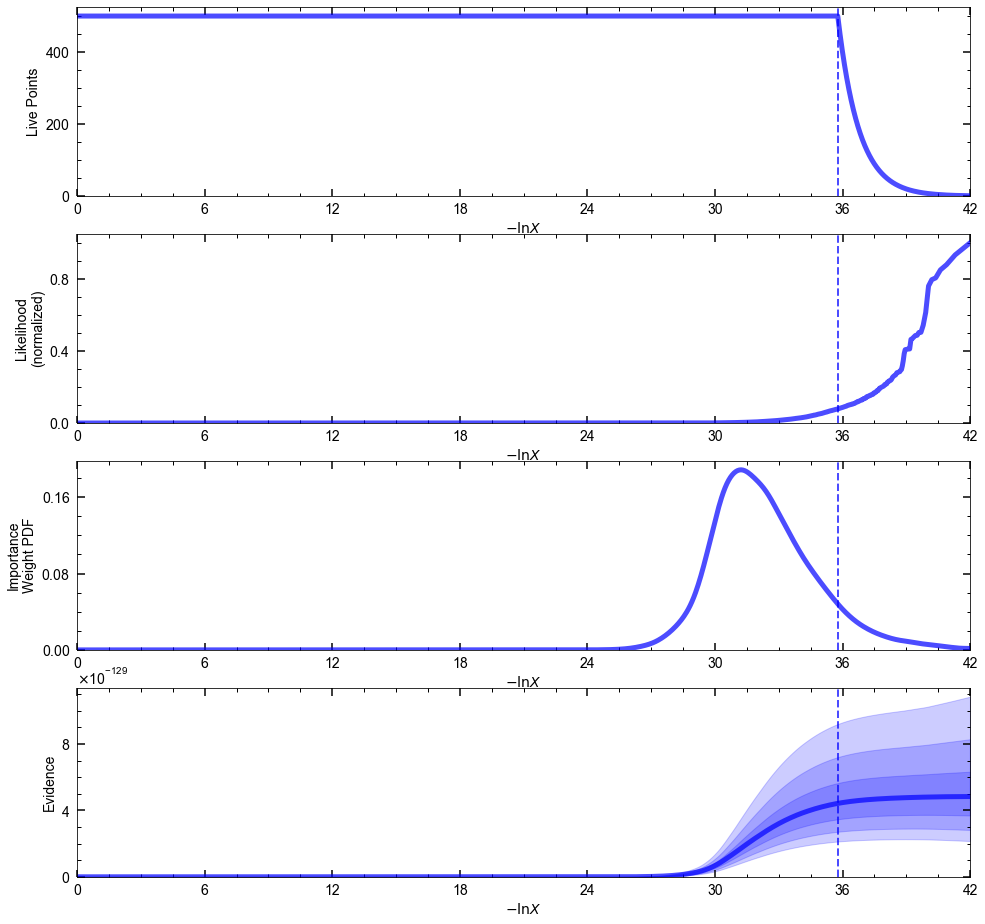

In [64]:
dyplot.runplot(dres)

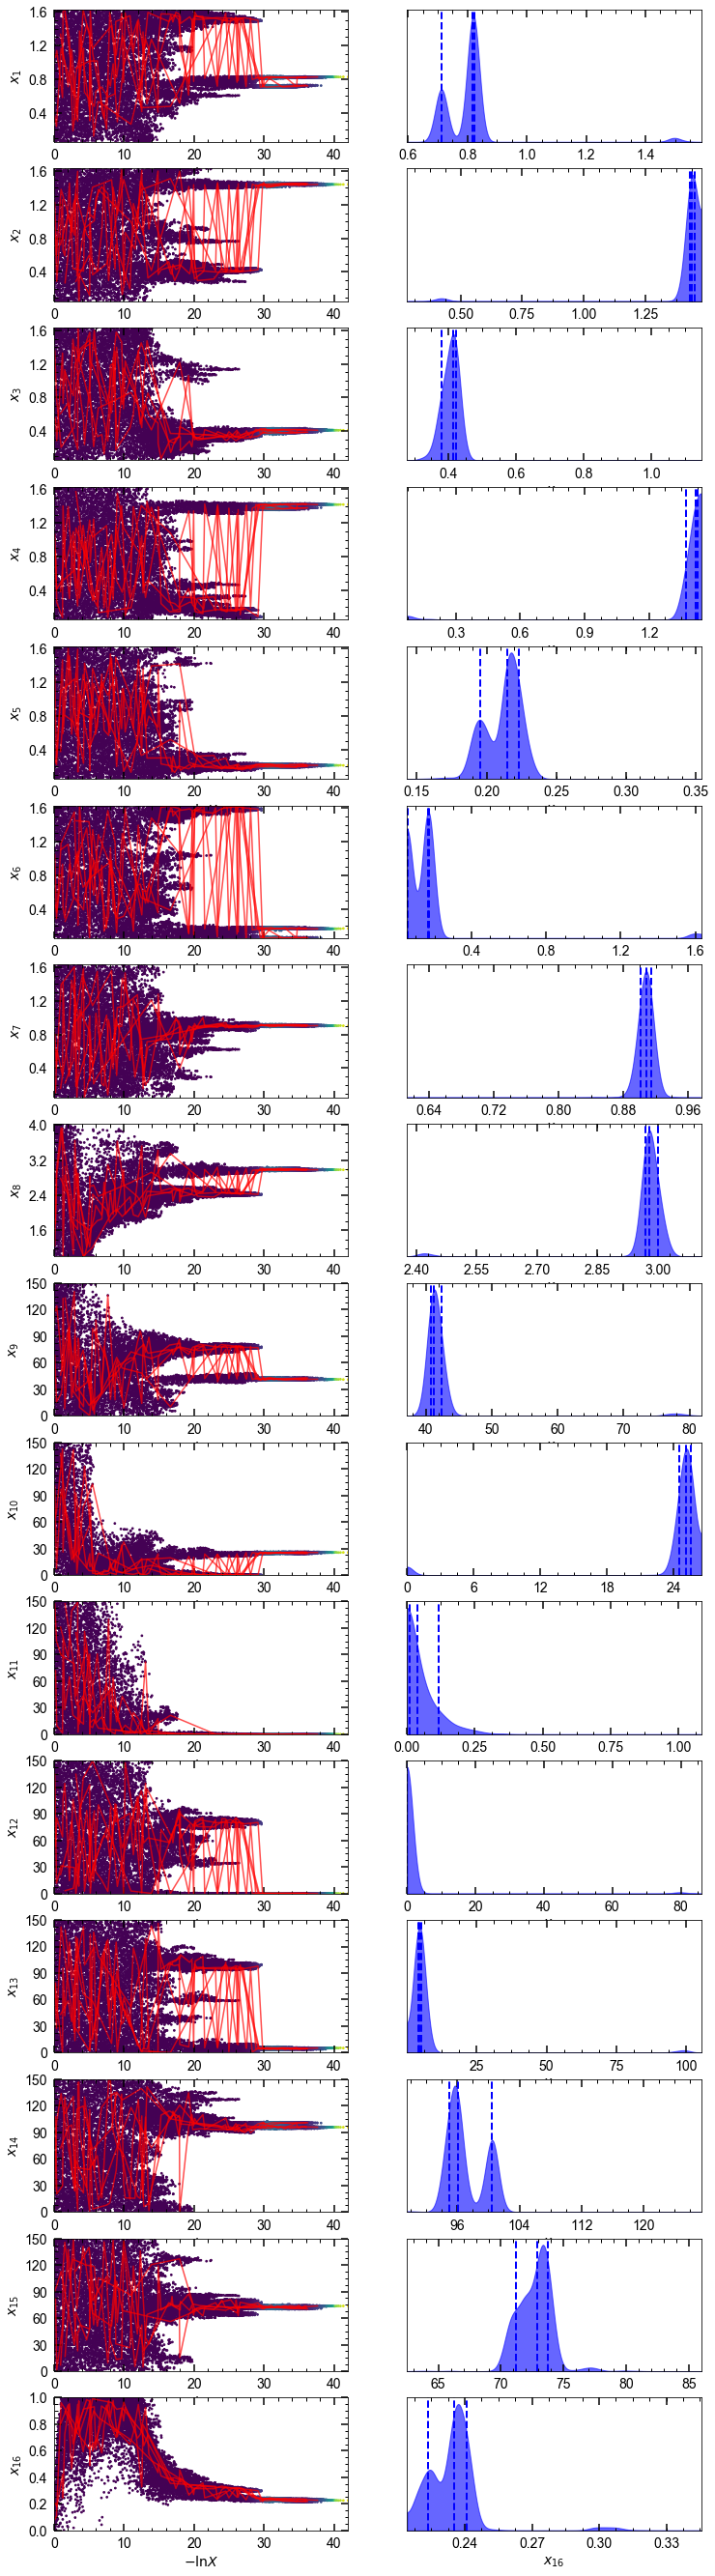

In [65]:
fig, axes = dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

In [34]:
# np.save('../data/out_dict/GSD_41520_assembly_3', dres)

(<Figure size 547.2x547.2 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a73adb080>,
       dtype=object))

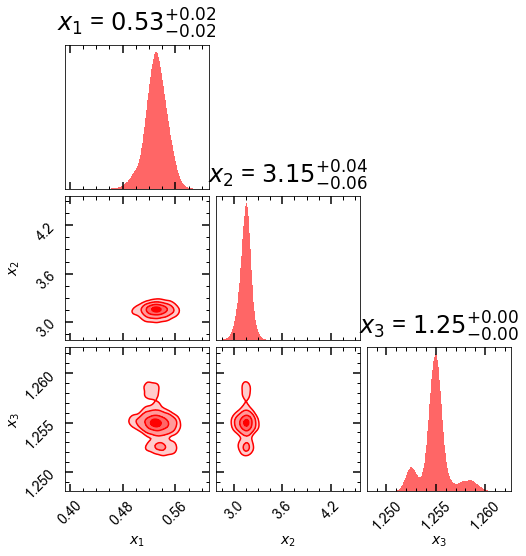

In [27]:
dyplot.cornerplot(dres2, color='red', truths=None, truth_color='black',#labels = ['Z','t','$\\tau$','z','Av'],
                           show_titles=True, title_kwargs={'y': 1.05}, 
                           quantiles=None, max_n_ticks=3, )

In [13]:
LBT

array([1.56, 2.8 , 3.73, 4.35, 4.67])

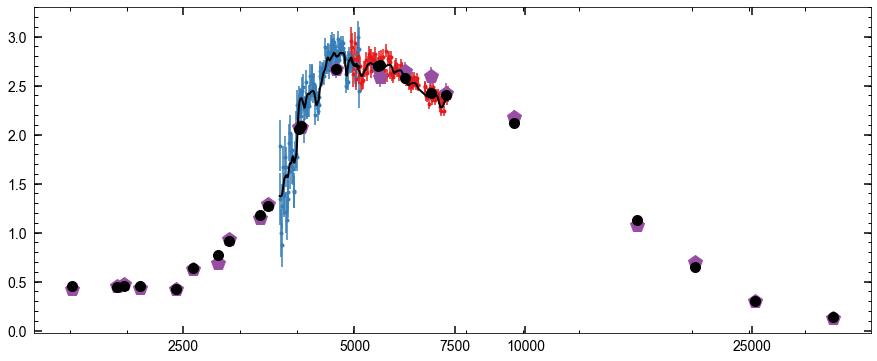

In [25]:
#  array([0.57029166, 3.07055345, 0.35029257, 1.24904928, 0.11330445]))

sp.params['logzsol'] = np.log10(0.58)
sp.params['tau'] = 0.31
sp.params['dust2'] = 0.11
    
wave,flux = sp.get_spectrum(tage = 2.73,peraa = True)
    
Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux , 1.25)

PC= Full_scale(Gs, Pmfl)

Bscale = Scale_model(Gs.SBfl, Gs.SBer, PC*Bmfl)
Rscale = Scale_model(Gs.SRfl, Gs.SRer, PC*Rmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.SBfl*1E18,Gs.SBer*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.SRfl*1E18,Gs.SRer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.SPflx*1E18,Gs.SPerr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)

In [31]:
sp.params['compute_light_ages'] = True

wave,flux = sp.get_spectrum(tage = 4.2)

print(interp1d(wave,flux)(4770))
sp.params['compute_light_ages'] = False


2.214131598293001


In [17]:
np.where(dres.logl == np.max(dres.logl)),np.max(dres.logl),dres.samples[23212]

((array([23212]),),
 -208.85208150766476,
 array([2.70641723e-01, 6.67155957e-01, 6.87389477e-01, 8.32059545e-01,
        1.25340266e+00, 1.41717829e+00, 4.56506094e+00, 5.74995179e-01,
        5.39438086e-01, 5.32047776e-01, 2.68029355e-02, 4.10062829e-03,
        4.37931106e-04, 1.25361941e+00, 1.04803298e-01]))

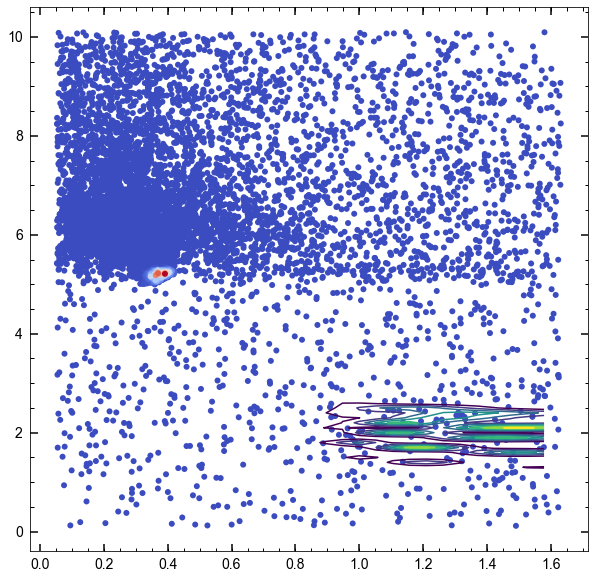

In [13]:
P = np.load('../../Quiescent_analysis/chidat/n21156_dtau_tZ_pos_lwa_dust.npy')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
M,A=np.meshgrid(metal/0.019,age)

plt.figure(figsize=(10, 10))
plt.scatter(dres.samples[:, 0], dres.samples[:, 1],
               marker='o', c=np.exp(dres.logl), linewidths=(0.,), cmap='coolwarm')

# plt.scatter(dres.samples[:, 0][IDX[242]], dres.samples[:, 1][IDX[242]],
#                marker='o', c='k')
plt.contour(M,A,P)


In [21]:
sp.params['compute_light_ages'] = True
lwa = np.zeros(len(dres.samples))
for i in range(len(dres.samples)):
    sp.params['logzsol'] = np.log10(dres.samples[i][0])
    sp.params['tau'] = dres.samples[i][2]
    sp.params['dust2'] = dres.samples[i][4]  
    wave, flux = sp.get_spectrum(tage = dres.samples[i][1])
    
    lwa[i] = interp1d(wave,flux)(4770)


In [40]:
sp.params['compute_light_ages'] = True
lwa2 = np.zeros(len(dres2.samples))
for i in range(len(dres2.samples)):
    sp.params['logzsol'] = np.log10(dres2.samples[i][0])
    sp.params['tau'] = dres2.samples[i][2]
    sp.params['dust2'] = dres2.samples[i][4]  
    wave, flux = sp.get_spectrum(tage = dres2.samples[i][1])
    
    lwa2[i] = interp1d(wave,flux)(4770)

In [38]:
sp.params['logzsol'] = np.log10(1)
sp.params['tau'] = 1
sp.params['dust2'] = 0.1  
wave, flux = sp.get_spectrum(tage = 0.5)
print(interp1d(wave,flux)(4770))

0.0920121117084283


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


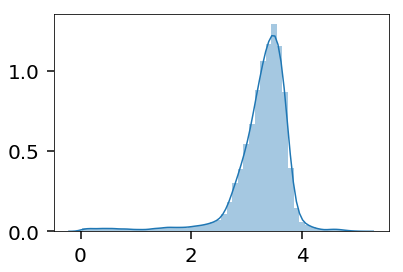

In [139]:
sea.distplot(dres1.samples[:,1])
# sea.distplot(lwa1)
# plt.xlim(0,5)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


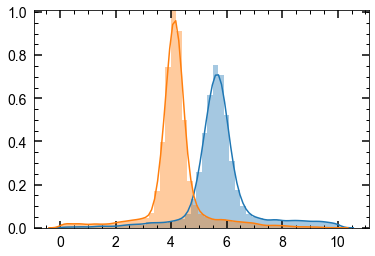

In [22]:
sea.distplot(dres.samples[:,1])
sea.distplot(lwa)

In [43]:
dres1.samples[:,1] = lwa1
dres2.samples[:,1] = lwa2

In [77]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

[2.92597421e-05]


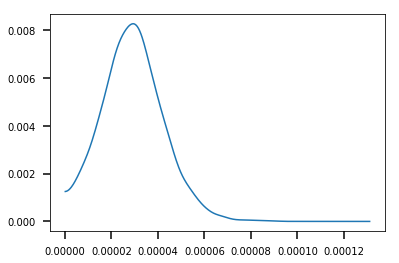

In [99]:
x,PX = Get_posterior(dres2b.samples[:,5], dres2['logwt'], dres2['logz'])

plt.plot(x,PX)
print(x[PX == max(PX)])

In [111]:
in1 = np.loadtxt('/Users/vestrada/alf/atlas_ssp_t03_Zp0.0.abund.krpa.s100').T

In [127]:
sp.params['logzsol'] = np.log10( 1 )
# sp.params['tau'] = 0.1
sp.params['sfh'] = 0

sp.params['dust2'] = 0.0

wave, flux = sp.get_spectrum(tage = 3, peraa = True)

(3.5, 4.5)

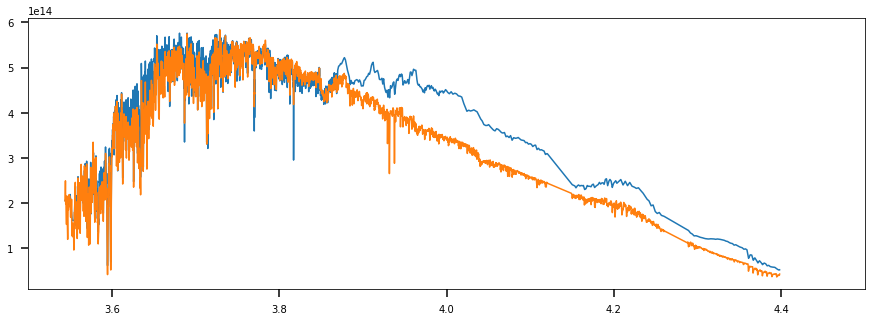

In [132]:
iflux = interp1d(wave,flux)(in1[0])
plt.figure(figsize=[15,5])
# plt.plot(np.log10(wave),flux*1.5E19)
plt.plot(np.log10(in1[0]), iflux*.9E19)
plt.plot(np.log10(in1[0]), (3E18 / in1[0]**2)*in1[1])



plt.xlim(3.5,4.5)

# review all completed cycles

In [31]:
dres1 = np.load('../data/out_dict/GND_21156_testfit_tmp_LF.npy').item()
dres2 = np.load('../data/out_dict/GND_21156_testfit_tmp_EF.npy').item()
dres3 = np.load('../data/out_dict/GND_21156_testfit_tmp_ND.npy').item()
dres4 = np.load('../data/out_dict/GND_21156_testfit_tmp_LF_tab.npy').item()
dres5 = np.load('../data/out_dict/GND_21156_testfit_tmp_EF_tab.npy').item()

dres6 = np.load('../data/out_dict/GND_21156_testfit_LF.npy').item()
dres7 = np.load('../data/out_dict/GND_21156_testfit_EF.npy').item()
dres8 = np.load('../data/out_dict/GND_21156_testfit_ND.npy').item()
dres9 = np.load('../data/out_dict/GND_21156_testfit_LF_tab.npy').item()

dres10 = np.load('../data/out_dict/GND_21156_testfit_EF_tab.npy').item()

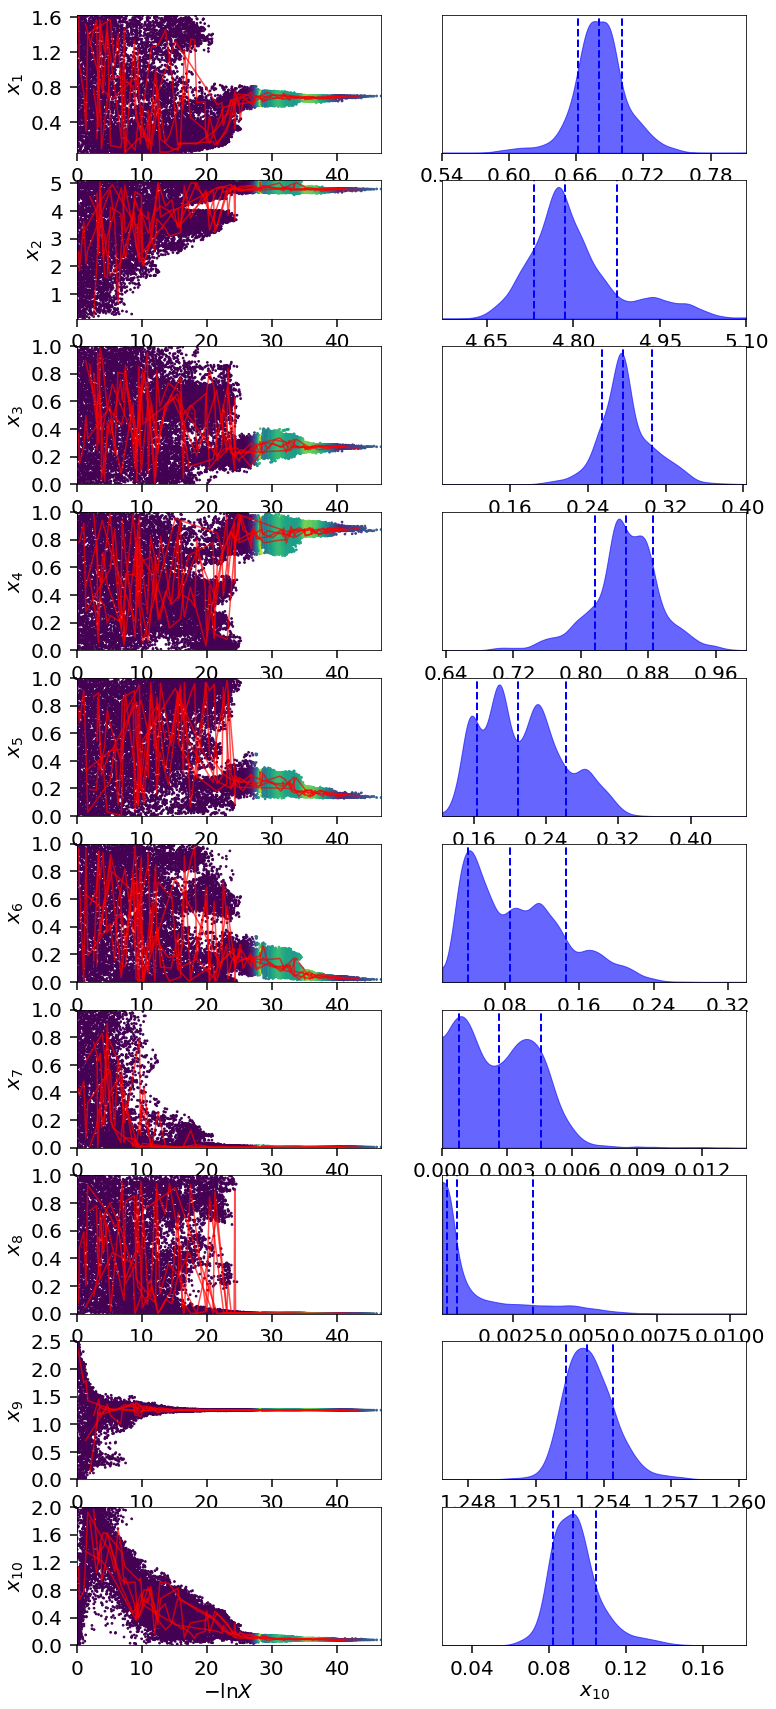

In [34]:
fig, axes = dyplot.traceplot(dres9, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

(<Figure size 1605.6x1605.6 with 100 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a88c549e8>,
       dtype=object))

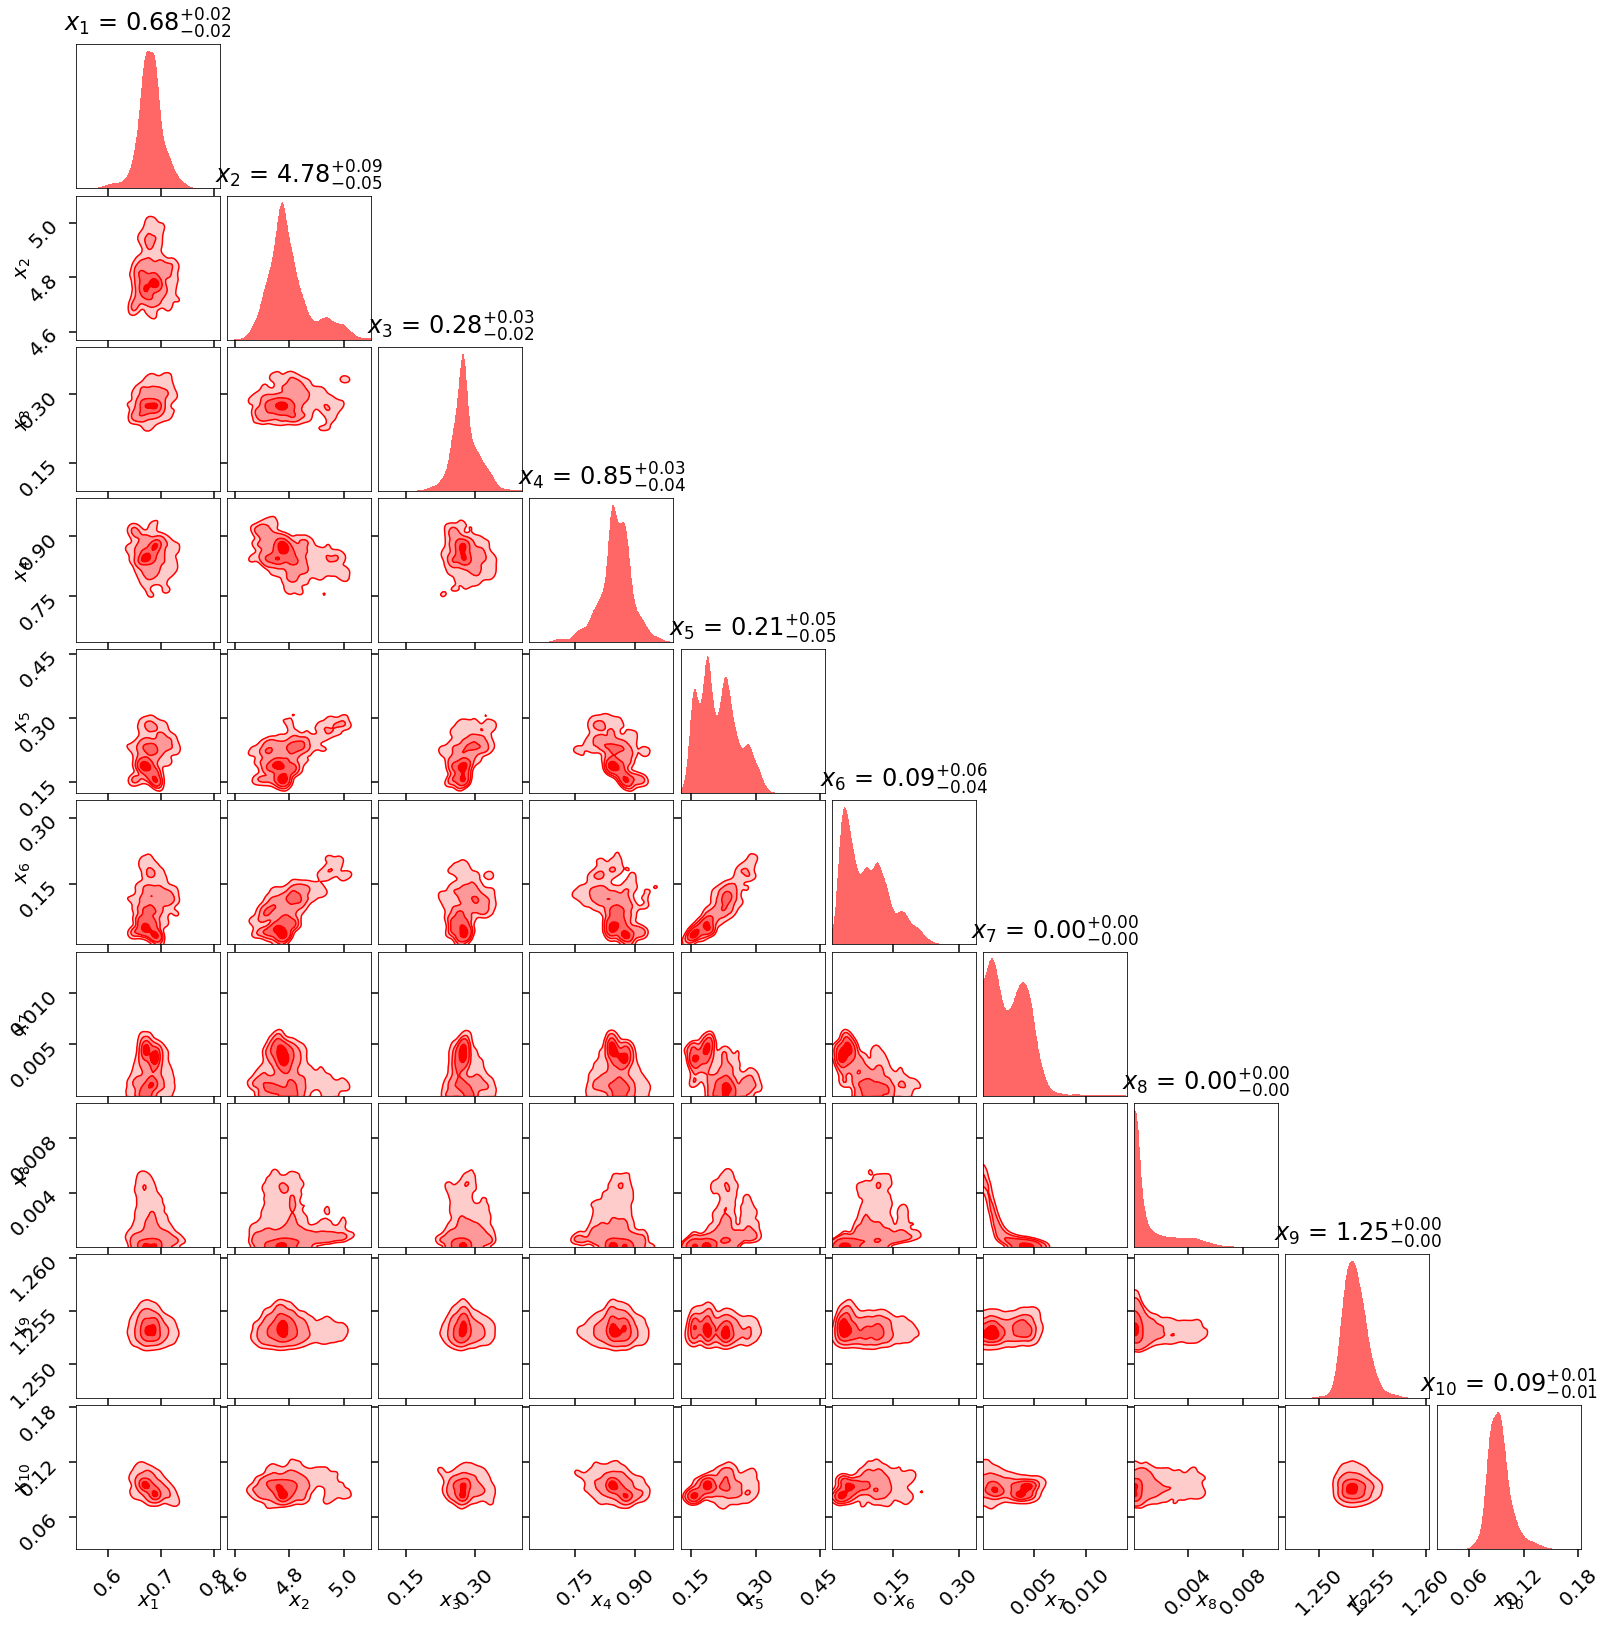

In [35]:
dyplot.cornerplot(dres9, color='red', truths=None, truth_color='black',#labels = ['Z','t','$\\tau$','z','Av'],
                           show_titles=True, title_kwargs={'y': 1.05}, 
                           quantiles=None, max_n_ticks=3, )

<ErrorbarContainer object of 3 artists>

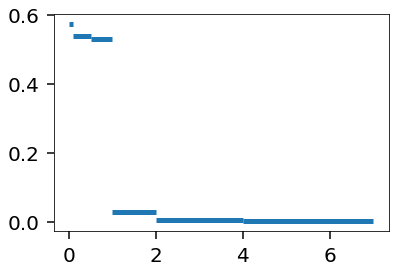

In [24]:
plt.errorbar(np.array([0.1, 0.5, 1, 2, 4, 7]),np.array([0.575, 0.539, 0.532, 0.027, 0.004,0.0004]),xerr = [[0.1,0.4,0.5,1,2,3],[0,0,0,0,0,0]],fmt = 'o',ms=0,linewidth=5)

<ErrorbarContainer object of 3 artists>

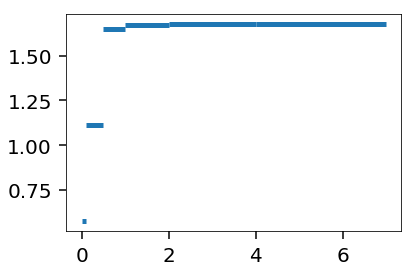

In [26]:
plt.errorbar(np.array([0.1, 0.5, 1, 2, 4, 7]),
             np.array([0.575, 0.539 + 0.575, 0.532 + 0.539 + 0.575, 0.027 + 0.532 + 0.539 + 0.575, 0.004 + 0.027 + 0.532 + 0.539 + 0.575,0.0004 + 0.004 + 0.027 + 0.532 + 0.539 + 0.575]),
             xerr = [[0.1,0.4,0.5,1,2,3],[0,0,0,0,0,0]],fmt = 'o',ms=0,linewidth=5)

In [33]:
np.where(dres1.logl == np.max(dres1.logl)),np.max(dres1.logl),dres1.samples[26460]

((array([26460]),),
 -93.11404487774317,
 array([0.32468948, 4.83708409, 0.49859328, 1.25364188, 0.20821861]))

In [35]:
np.where(dres6.logl == np.max(dres6.logl)),np.max(dres6.logl),dres6.samples[28730]

((array([28730]),),
 -212.87524121550115,
 array([0.6280001 , 5.09097778, 0.54372305, 1.25261409, 0.08475945]))

In [41]:
np.where(dres7.logl == np.max(dres7.logl)),np.max(dres7.logl),dres7.samples[28603]

((array([28603]),),
 -211.80592481091657,
 array([0.60347418, 5.68625517, 0.61053635, 1.25292823, 0.07791594]))

In [38]:
np.where(dres9.logl == np.max(dres9.logl)),np.max(dres9.logl),dres9.samples[32110]

((array([32110]),),
 -212.07630523308626,
 array([7.01082532e-01, 4.78812212e+00, 2.72526675e-01, 8.73381849e-01,
        1.34358664e-01, 1.78666045e-02, 5.39302455e-03, 1.37082047e-04,
        1.25280924e+00, 7.94224483e-02]))

In [69]:
np.where(dres10.logl == np.max(dres10.logl)),np.max(dres10.logl),dres10.samples[27588]

((array([27588]),),
 -205.36900949085887,
 array([ 0.64668916, 10.09676873,  0.30959742,  0.9492099 ,  0.88531001,
         0.6769806 ,  0.81779508,  0.14122372,  0.04172833,  1.25335991,
         0.10707565]))

In [13]:
np.where(dres.logl == np.max(dres.logl)),np.max(dres.logl),dres.samples[35673]

((array([35673]),),
 -199.3968913053439,
 array([5.95557527e-01, 9.66809769e-01, 1.49535237e+00, 2.32900348e-01,
        7.15368984e-02, 1.49897341e+00, 4.97765566e+00, 3.55015018e-01,
        1.80599659e-01, 8.20441816e-01, 4.34977115e-01, 1.00547157e-03,
        4.34187149e-03, 1.25319095e+00, 2.40421865e-01]))

432.4787478296225


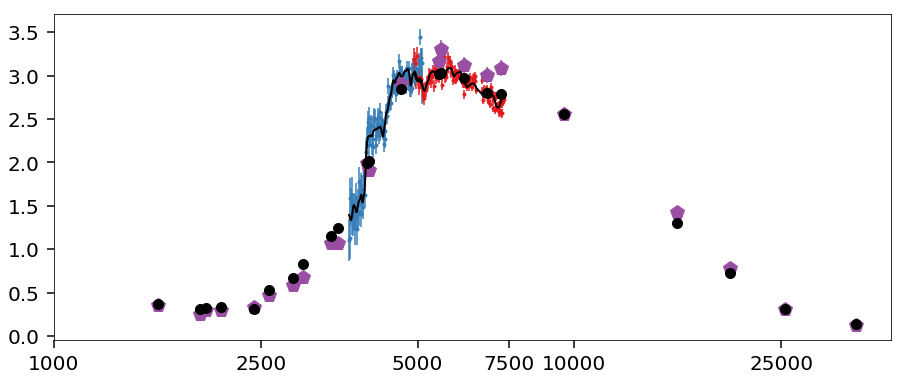

In [64]:
Gs.Sim_all(0.012/0.019, 4.93, 0.545, 1.2529, 0.06)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

442.4641927282162


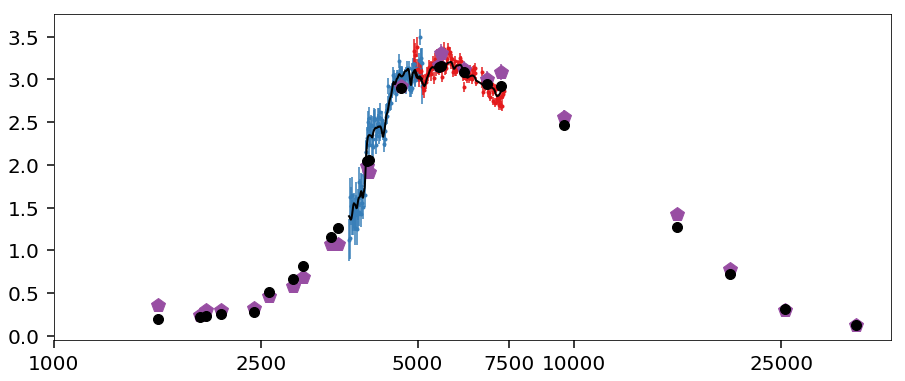

In [65]:
Gs.Sim_all(0.32468948, 4.83708409, 0.49859328, 1.25364188, 0.20821861)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

416.6229833301954


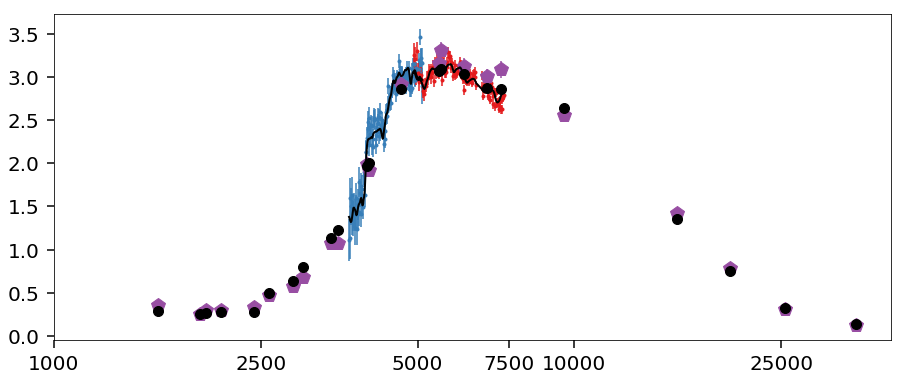

In [66]:
Gs.Sim_all(0.6280001 , 5.09097778, 0.54372305, 1.25261409, 0.08475945)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

416.9092782718844


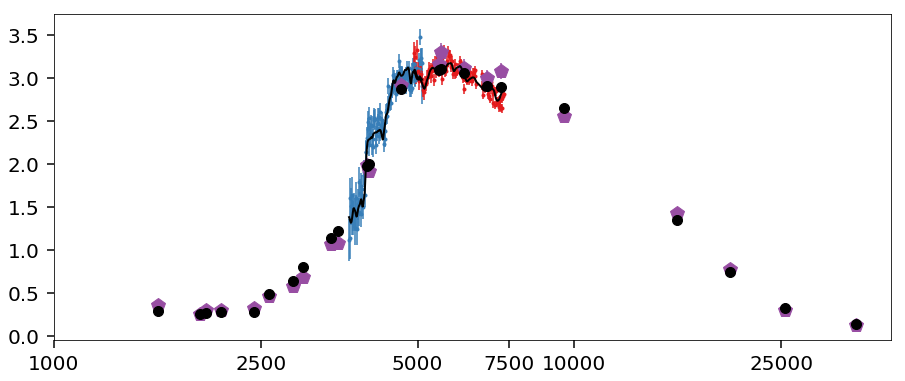

In [67]:
Gs.Sim_all(0.60347418, 5.68625517, 0.61053635, 1.25292823, 0.07791594)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

In [39]:
0.2725, 0.8734, 0.1344, 0.0179, 0.0054, 0.0001,


sp.params['sfh'] = 3
sp.params['logzsol'] = np.log10( 0.70108)
sp.params['dust2'] = 0.079
sp.set_tabular_sfh(np.array([0.1, 0.5, 1, 2, 4, 6]),np.array([0.2725, 0.8734, 0.1344, 0.0179, 0.0054, 0.0001]))

wave,flux = sp.get_spectrum(tage = 4.788,peraa=True)
sp.params['sfh'] = 4

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


347.37621271091797


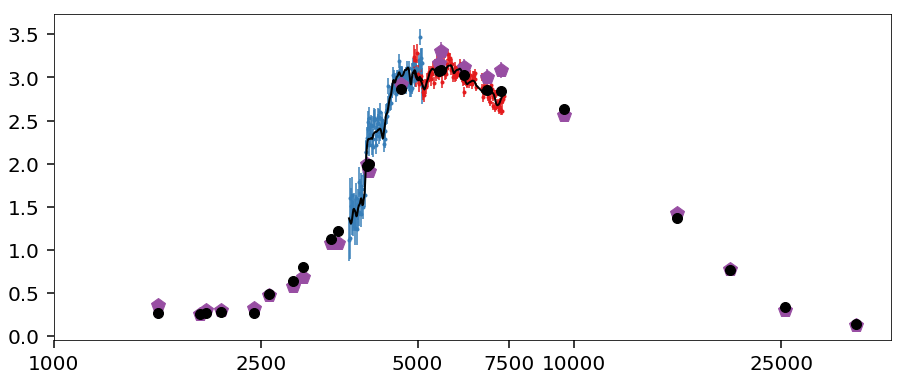

In [47]:
Gs = Gen_spec('GND', 21156, 1.25378,
               g102_lims=[8300, 11500], g141_lims=[11100, 16500],mdl_err = False, instr_err = False,
            phot_errterm = 0.03, decontam = True) 

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux , 1.25280924)

PC= Scale_model(Gs.Pflx,Gs.Perr,Pmfl)

Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC*Bmfl)
Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC*Rmfl)

Bchi= np.sum(( (Gs.Bfl / Bscale - PC*Bmfl) / Gs.Ber/ Bscale)**2) 
Rchi= np.sum(( (Gs.Rfl / Rscale - PC*Rmfl) / Gs.Rer/ Rscale)**2) 
Pchi= np.sum(( (Gs.Pflx - PC*Pmfl) / Gs.Perr)**2) 

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18/ Bscale,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18/ Rscale,Gs.Rer*1E18/ Rscale,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
print(Bchi + Rchi + Pchi)

In [16]:
sp.params['sfh'] = 3
sp.params['dust2'] = 0.24
sp.set_tabular_sfh(np.array([0.1, 0.5, 1, 2, 4, 7]),np.array([0.355, 0.18, 0.82, 0.435, 0.001,0.004]),
        Z = np.array([0.5956, 0.96681, 1.495, 0.233, 0.07, 1.498]) * 0.019)

wave,flux = sp.get_spectrum(tage =4.977,peraa=True)
sp.params['sfh'] = 4


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


400.81530599661414


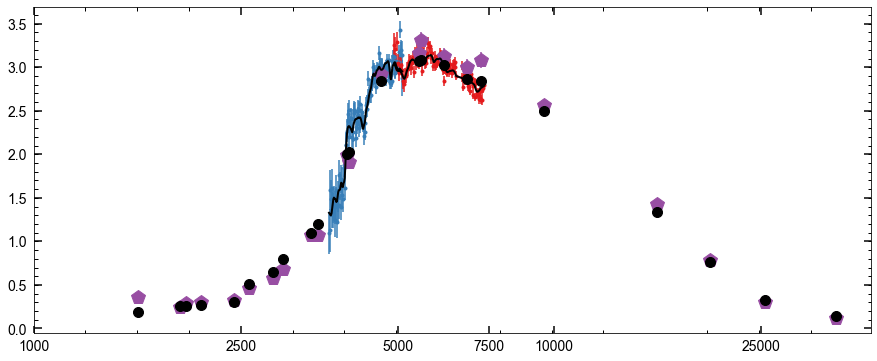

In [17]:
Gs = Gen_spec('GND', 21156, 1.25378,
               g102_lims=[8300, 11500], g141_lims=[11100, 16500],mdl_err = False, instr_err = False,
            phot_errterm = 0.03, decontam = True) 

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux , 1.25319)

PC= Full_scale(Gs, Pmfl)

Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC*Bmfl)
Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC*Rmfl)

Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18/ Bscale,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18/ Rscale,Gs.Rer*1E18/ Rscale,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
print(Bchi + Rchi + Pchi)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


([<matplotlib.axis.XTick at 0x1a7bff2cc0>,
 <a list of 6 Text xticklabel objects>)

<Figure size 1080x432 with 0 Axes>

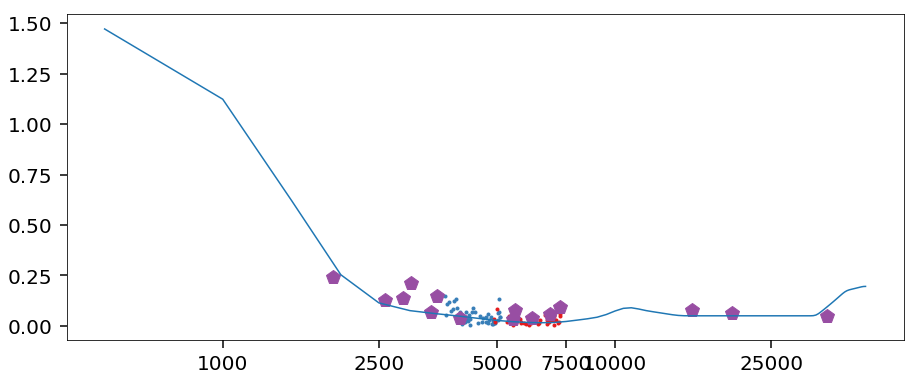

In [98]:
Gs.Sim_all(0.012/0.019, 4.93, 0.545, 1.2529, 0.06)
plt.figure(figsize = [15,6])
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),np.sqrt(((Gs.Bfl - Gs.Bmfl) / Gs.Bfl)**2 - (Gs.Ber / Gs.Bfl)**2), 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),np.sqrt(((Gs.Rfl - Gs.Rmfl) / Gs.Rfl)**2 - (Gs.Rer / Gs.Rfl)**2), 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),np.sqrt(((Gs.Pflx- Gs.Pmfl) / Gs.Pflx)**2 - (Gs.Perr / Gs.Pflx)**2),
                'p', markersize=15, color='#984ea3')
plt.plot(np.log10(wv),tmp)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


([<matplotlib.axis.XTick at 0x1a919d2b00>,
 <a list of 6 Text xticklabel objects>)

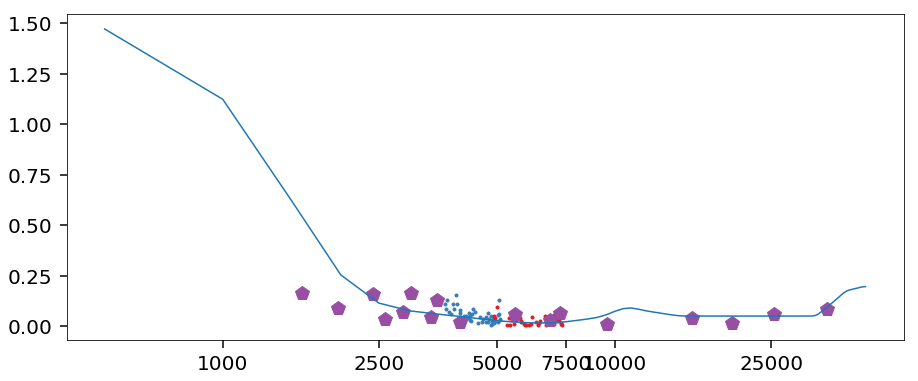

In [49]:
Gs.Sim_all(0.6280001 , 5.09097778, 0.54372305, 1.25261409, 0.08475945)
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),np.sqrt(((Gs.Bfl - Gs.Bmfl) / Gs.Bfl)**2 - (Gs.Ber / Gs.Bfl)**2), 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),np.sqrt(((Gs.Rfl - Gs.Rmfl) / Gs.Rfl)**2 - (Gs.Rer / Gs.Rfl)**2), 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),np.sqrt(((Gs.Pflx- Gs.Pmfl) / Gs.Pflx)**2 - (Gs.Perr / Gs.Pflx)**2),
                'p', markersize=15, color='#984ea3')
plt.plot(np.log10(wv),tmp)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


([<matplotlib.axis.XTick at 0x1a912b0438>,
 <a list of 6 Text xticklabel objects>)

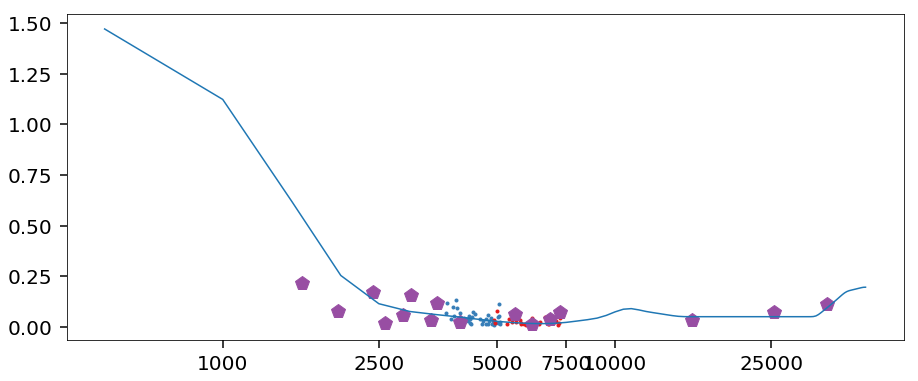

In [48]:
wv,tmp = np.load('../templates/mdl_EF.npy')
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),np.sqrt(((Gs.Bfl/ Bscale - PC*Bmfl) / Gs.Bfl/ Bscale)**2 - (Gs.Ber / Gs.Bfl)**2), 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),np.sqrt(((Gs.Rfl / Rscale- PC*Rmfl) / Gs.Rfl/ Rscale)**2 - (Gs.Rer / Gs.Rfl)**2), 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),np.sqrt(((Gs.Pflx- PC*Pmfl) / Gs.Pflx)**2 - (Gs.Perr / Gs.Pflx)**2),
                'p', markersize=15, color='#984ea3')
plt.plot(np.log10(wv),tmp)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

([<matplotlib.axis.XTick at 0x1a8e753dd8>,
 <a list of 6 Text xticklabel objects>)

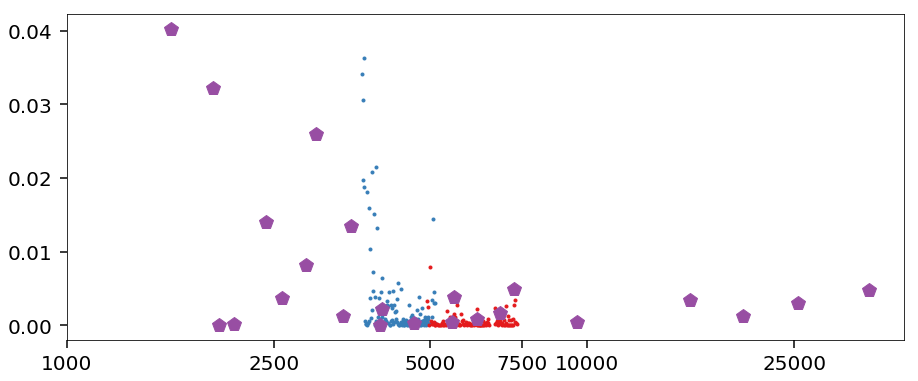

In [95]:
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),((Gs.Bfl/ Bscale - PC*Bmfl) / Gs.Bfl/ Bscale)**2 , 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),((Gs.Rfl / Rscale- PC*Rmfl) / Gs.Rfl/ Rscale)**2 , 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),((Gs.Pflx- PC*Pmfl) / Gs.Pflx)**2 ,
                'p', markersize=15, color='#984ea3')

# plt.plot(np.log10(Gs.Bwv_rf),((Gs.Bfl - Gs.Bmfl) / Gs.Bfl)**2, 
#                 'o', markersize=3, color='k')
# plt.plot(np.log10(Gs.Rwv_rf),((Gs.Rfl - Gs.Rmfl) / Gs.Rfl)**2, 
#                 'o', markersize=3, color='k')
# plt.plot(np.log10(Gs.Pwv_rf),((Gs.Pflx- Gs.Pmfl) / Gs.Pflx)**2,
#                 'p', markersize=15, color='k')

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

In [ ]:
asdf